In [1]:
# testing the subtract model
import tensorflow as tf
from tensorflow import keras
import numpy as np

In [2]:
# generate dummy data


# generate a data that is pep one hot encoding with N=14, d=21. mhc_emb with N= 312 and d =1152. a contact map that is a soft weights over 312 mhc positions

# Create dummy data
num_samples = 1000

# Peptide One-Hot Encoding (N=14, d=21)
pep_len = 14
pep_alphabet_size = 21
pep_indices = np.random.randint(0, pep_alphabet_size, size=(num_samples, pep_len))
pep_OHE = tf.one_hot(pep_indices, depth=pep_alphabet_size, dtype=tf.float32)

# MHC Embedding (N=312, d=1152)
mhc_len = 312
mhc_embedding_dim = 1152
mhc_emb = tf.random.normal(shape=(num_samples, mhc_len, mhc_embedding_dim))

# Define pad and mask tokens
pad_token = -2.0
mask_token = -1.0

# Generate peptide mask
# Let's assume a variable number of padded/masked tokens per sample
pep_mask = np.ones((num_samples, pep_len), dtype=np.float32)
for i in range(num_samples):
    # Add 0 to 3 padded tokens at the end
    num_padded = np.random.randint(0, 4)
    if num_padded > 0:
        pep_mask[i, -num_padded:] = pad_token
    # Add 0 to 2 masked tokens at random positions that are not padded
    num_masked = np.random.randint(0, 3)
    valid_indices = np.where(pep_mask[i] == 1.0)[0]
    if num_masked > 0 and len(valid_indices) >= num_masked:
        mask_indices = np.random.choice(valid_indices, num_masked, replace=False)
        pep_mask[i, mask_indices] = mask_token

pep_mask = tf.constant(pep_mask, dtype=tf.float32)

# Generate MHC mask (similar logic)
mhc_mask = np.ones((num_samples, mhc_len), dtype=np.float32)
for i in range(num_samples):
    # Add 0 to 10 padded tokens
    num_padded = np.random.randint(0, 11)
    if num_padded > 0:
        mhc_mask[i, -num_padded:] = pad_token
mhc_mask = tf.constant(mhc_mask, dtype=tf.float32)


# Zero out masked positions in the data
# Create boolean masks where True means the position is valid (not padded or masked)
pep_bool_mask = tf.cast(pep_mask > 0, dtype=tf.float32)
mhc_bool_mask = tf.cast(mhc_mask > 0, dtype=tf.float32)

# Apply masks to zero out data. Unsqueeze to allow broadcasting.
pep_OHE = pep_OHE * pep_bool_mask[:, :, tf.newaxis]
mhc_emb = mhc_emb * mhc_bool_mask[:, :, tf.newaxis]


# print samples of the data
print("Peptide OHE shape:", pep_OHE.shape)
print("Peptide OHE sample (first 2 samples):", pep_OHE[:2])
print("Peptide mask shape:", pep_mask.shape)
print("Peptide mask sample (first 2 samples):", pep_mask[:2])


print("MHC Embedding shape:", mhc_emb.shape)
print("MHC Embedding sample (first 2 samples):", mhc_emb[:2])
print("MHC mask shape:", mhc_mask.shape)
print("MHC mask sample (first 2 samples):", mhc_mask[:2])

Peptide OHE shape: (1000, 14, 21)
Peptide OHE sample (first 2 samples): tf.Tensor(
[[[0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
  [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

In [3]:
# model

class SubtractLayer(keras.layers.Layer):
    """
    Custom layer to subtract a tensor from another tensor.
    Tensor1: (B, P, D) -> (B, P*D) -> (B, M, P*D)
    Tensor2: (B, M, D) -> (B, M, P*D)
    Output: = Tensor2 - Tensor1
    """
    def __init__(self, mask_token=-1., pad_token=-2., **kwargs):
        """Initialize the layer."""
        super(SubtractLayer, self).__init__(**kwargs)
        self.mask_token = mask_token
        self.pad_token = pad_token

    def call(self, peptide, pep_mask, mhc, mhc_mask):
        B = tf.shape(peptide)[0]
        P = tf.shape(peptide)[1]
        D = tf.shape(peptide)[2]
        M = tf.shape(mhc)[1]
        P_D = P * D

        pep_mask = tf.cast(pep_mask, tf.float32)
        mhc_mask = tf.cast(mhc_mask, tf.float32)

        pep_mask = tf.where(pep_mask == self.pad_token, x=0., y=1.)  # (B,P)
        mhc_mask = tf.where(mhc_mask == self.pad_token, x=0., y=1.)

        # peptide  (B,P,D) -> (B,P*D) -> (B,M,P*D)
        peptide_flat = tf.reshape(peptide, (B, P_D))
        peptide_exp = tf.repeat(peptide_flat[:, tf.newaxis, :], repeats=M, axis=1)
        # mhc       (B,M,D) -> tile last axis P times -> (B,M,P*D)
        mhc_exp = tf.tile(mhc, [1, 1, P])
        result = mhc_exp - peptide_exp  # (B,M,P*D)
        # peptide mask  (B,P) -> (B,P,D) -> flatten -> (B,P*D) -> (B,M,P*D)
        pep_mask_PD = tf.tile(pep_mask[:, :, tf.newaxis], [1, 1, D])  # (B,P,D)
        pep_mask_PD = tf.reshape(pep_mask_PD, (B, P_D))  # (B,P*D)
        pep_mask_PD = tf.repeat(pep_mask_PD[:, tf.newaxis, :], repeats=M, axis=1)  # (B,M,P*D)
        # mhc mask      (B,M) -> (B,M,1) -> repeat P*D along last axis
        mhc_mask_PD = tf.repeat(mhc_mask[:, :, tf.newaxis], repeats=P_D, axis=2)  # (B,M,P*D)
        combined_mask = tf.logical_and(tf.cast(pep_mask_PD, tf.bool), tf.cast(mhc_mask_PD, tf.bool))
        masked_result = tf.where(combined_mask, result, tf.zeros_like(result))
        return masked_result

Peptide OHE shape: (1000, 14, 21)
Peptide mask shape: (1000, 14)
Compatible MHC embedding shape: (1000, 312, 21)
MHC mask shape: (1000, 312)
Output tensor shape: (1000, 312, 294)


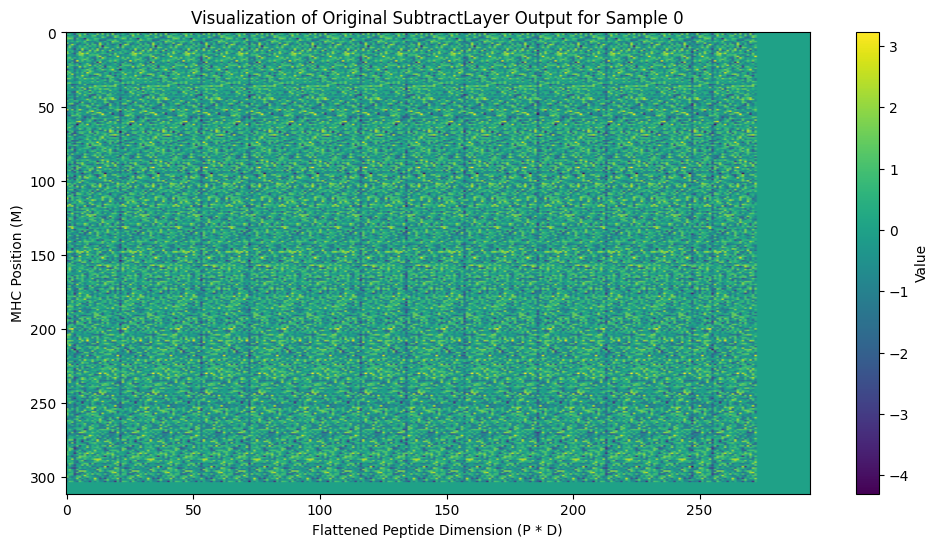

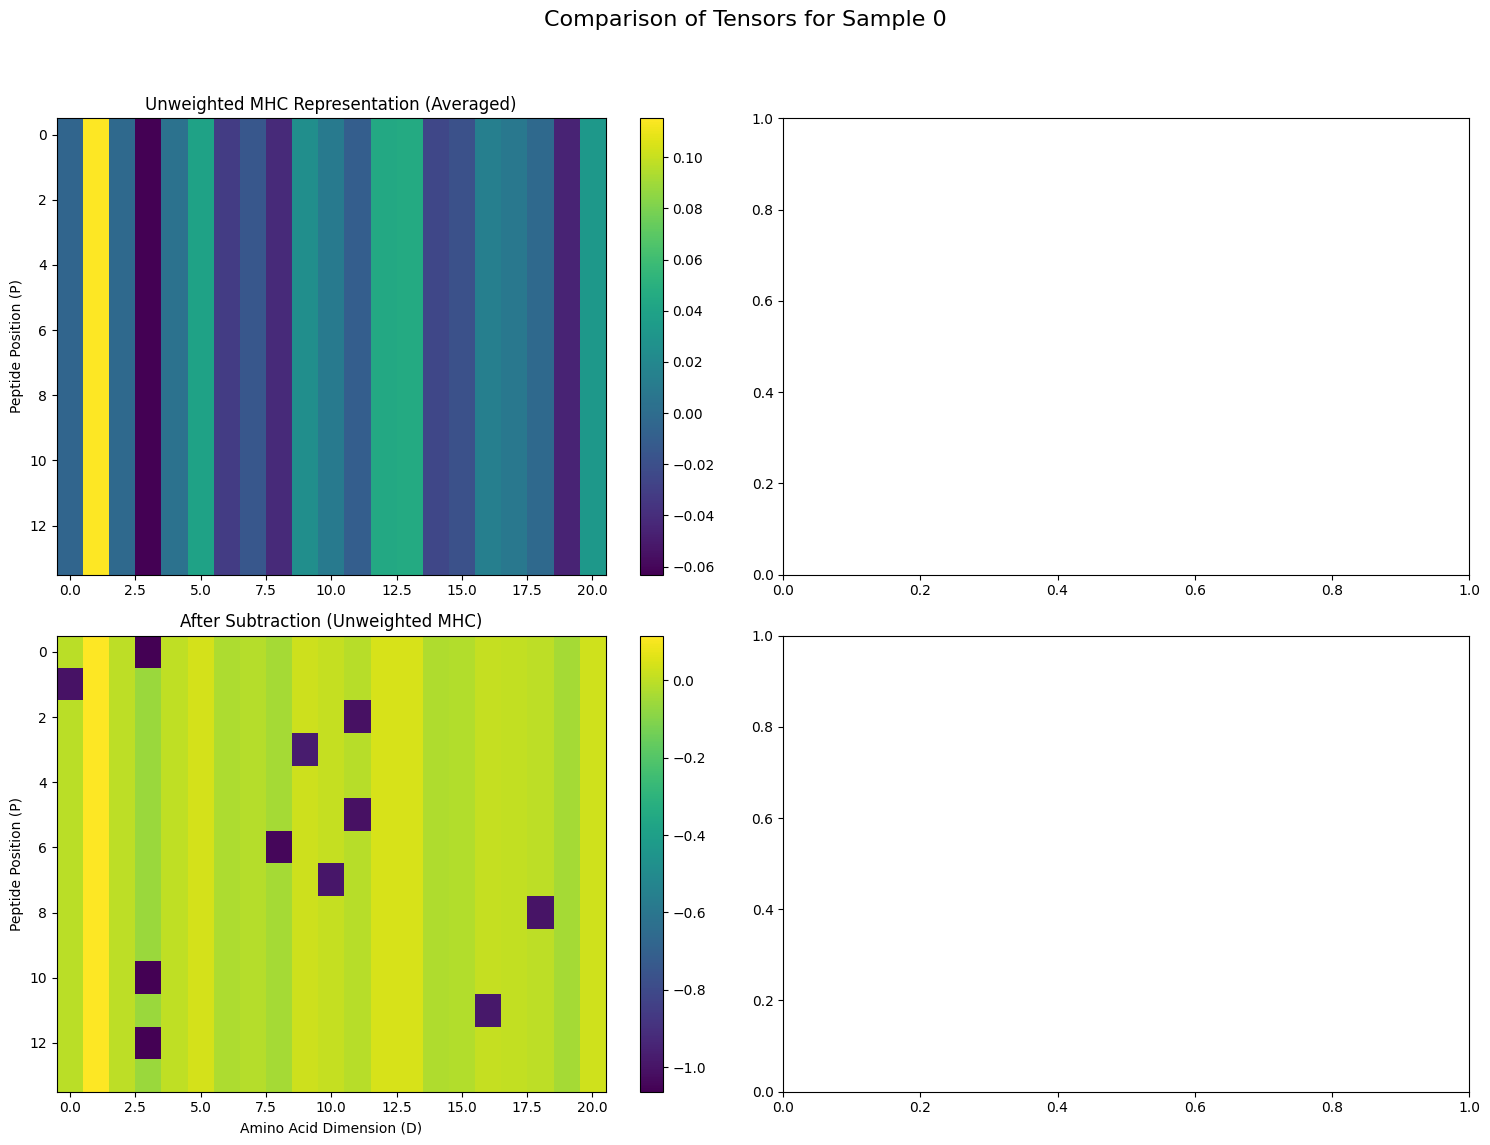

In [4]:
from tensorflow import keras

# The SubtractLayer expects peptide and mhc tensors to have the same last dimension.
# Let's create a dummy mhc tensor with the correct shape for the test.
# The last dimension should match pep_OHE's last dimension (pep_alphabet_size = 21).
mhc_compatible_emb = tf.random.normal(shape=(num_samples, mhc_len, pep_alphabet_size))

# Instantiate the layer
subtract_layer = SubtractLayer()

# Call the layer with the dummy data
output_tensor = subtract_layer(pep_OHE, pep_mask, mhc_compatible_emb, mhc_mask)

# Print the shapes to verify the output
print("Peptide OHE shape:", pep_OHE.shape)
print("Peptide mask shape:", pep_mask.shape)
print("Compatible MHC embedding shape:", mhc_compatible_emb.shape)
print("MHC mask shape:", mhc_mask.shape)
print("Output tensor shape:", output_tensor.shape)

# Visualize a small part of the output for one sample
import matplotlib.pyplot as plt

# Let's check the first sample
sample_index = 0
output_sample = output_tensor[sample_index].numpy()

# Reshape output tensor to (M, P, D) for easier visualization and weighting
B, M, PD = output_tensor.shape
P = pep_len
D = pep_alphabet_size
output_tensor_reshaped = tf.reshape(output_tensor, (B, M, P, D))


# We want to get (B, P, D)
# Transpose mhc and contact map for batch matrix multiplication
mhc_transposed = tf.transpose(mhc_compatible_emb, perm=[0, 2, 1]) # (B, D, M)


# Create an unweighted MHC representation for comparison by averaging over the M dimension
unweighted_mhc_for_subtraction = tf.tile(tf.reduce_mean(mhc_compatible_emb, axis=1, keepdims=True), [1, P, 1])
unweighted_subtraction_output = unweighted_mhc_for_subtraction - pep_OHE


plt.figure(figsize=(12, 6))
plt.title(f"Visualization of Original SubtractLayer Output for Sample {sample_index}")
plt.imshow(output_sample, aspect='auto', cmap='viridis')
plt.xlabel("Flattened Peptide Dimension (P * D)")
plt.ylabel("MHC Position (M)")
plt.colorbar(label="Value")
plt.show()

# Visualize the comparisons in a 2x2 grid
unweighted_mhc_sample = unweighted_mhc_for_subtraction[sample_index].numpy()
unweighted_sub_sample = unweighted_subtraction_output[sample_index].numpy()

fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle(f"Comparison of Tensors for Sample {sample_index}", fontsize=16)

# Top-left: Unweighted MHC
im = axes[0, 0].imshow(unweighted_mhc_sample, aspect='auto', cmap='viridis')
axes[0, 0].set_title("Unweighted MHC Representation (Averaged)")
axes[0, 0].set_ylabel("Peptide Position (P)")
fig.colorbar(im, ax=axes[0, 0])

# Bottom-left: Unweighted Subtraction
im = axes[1, 0].imshow(unweighted_sub_sample, aspect='auto', cmap='viridis')
axes[1, 0].set_title("After Subtraction (Unweighted MHC)")
axes[1, 0].set_xlabel("Amino Acid Dimension (D)")
axes[1, 0].set_ylabel("Peptide Position (P)")
fig.colorbar(im, ax=axes[1, 0])



plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [5]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

class SelfAttentionWith2DMask(keras.layers.Layer):
    """
    Custom self-attention layer that supports 2D masks.
    """
    def __init__(self, query_dim, context_dim, output_dim, heads=4,
                 return_att_weights=False, name='SelfAttentionWith2DMask',
                 epsilon=1e-6, mask_token=-1., pad_token=-2., do_not_mask_mhc=False):
        super().__init__(name=name)
        self.query_dim = query_dim
        self.context_dim = context_dim
        self.output_dim = output_dim
        self.heads = heads
        self.return_att_weights = return_att_weights
        self.epsilon = epsilon
        self.mask_token = mask_token
        self.pad_token = pad_token
        self.att_dim = output_dim // heads  # Attention dimension per head
        self.do_not_mask_mhc = do_not_mask_mhc

    def build(self, x):
        # Projection weights
        self.norm1 = layers.LayerNormalization(epsilon=self.epsilon, name=f'ln1_{self.name}')
        self.q_proj = self.add_weight(shape=(self.heads, self.query_dim, self.att_dim),
                                      initializer='random_normal', trainable=True, name=f'q_proj_{self.name}')
        self.k_proj = self.add_weight(shape=(self.heads, self.context_dim, self.att_dim),
                                      initializer='random_normal', trainable=True, name=f'k_proj_{self.name}')
        self.v_proj = self.add_weight(shape=(self.heads, self.context_dim, self.att_dim),
                                      initializer='random_normal', trainable=True, name=f'v_proj_{self.name}')
        self.g_proj = self.add_weight(shape=(self.heads, self.query_dim, self.att_dim),
                                      initializer='random_uniform', trainable=True, name=f'g_proj_{self.name}')
        self.norm2 = layers.LayerNormalization(epsilon=self.epsilon, name=f'ln2_{self.name}')


        self.out_w = self.add_weight(shape=(self.heads * self.att_dim, self.output_dim),
                                     initializer='random_normal', trainable=True, name=f'outw_{self.name}')
        self.out_b = self.add_weight(shape=(self.output_dim,), initializer='zeros',
                                     trainable=True, name=f'outb_{self.name}')
        self.scale = 1.0 / tf.math.sqrt(tf.cast(self.att_dim, tf.float32))

    def call(self, x_pmhc, p_mask, m_mask):
        """
        Args:
            x: Tensor of shape (B, N+M, query_dim) for query.
            mask: Tensor of shape (B, N, M) for 2D mask.
        :param x:
        :param mask:
        :return:
        """
        x_pmhc = self.norm1(x_pmhc)  # Normalize input
        p_mask = tf.cast(p_mask, tf.float32)
        m_mask = tf.cast(m_mask, tf.float32)
        p_mask = tf.where(p_mask==self.pad_token, x=0., y=1.)  # (B, N)
        m_mask = tf.where(m_mask==self.pad_token, x=0., y=1.)  # (B, M)

        q = tf.einsum('bxd,hde->bhxe', x_pmhc , self.q_proj)  # (B, N+M, E) * (H, E, D) -> (B, H, N+M, D)
        k = tf.einsum('bxd,hde->bhxe', x_pmhc, self.k_proj) # (B, N+M, E) * (H, E, D) -> (B, H, N+M, D)
        v = tf.einsum('bxd,hde->bhxe', x_pmhc, self.v_proj) # (B, N+M, E) * (H, E, D) -> (B, H, N+M, D)
        g = tf.einsum('bxd,hde->bhxe', x_pmhc, self.g_proj)  # (B, N+M, E) * (H, E, D) -> (B, H, N+M, D)

        att = tf.matmul(q, k, transpose_b=True) * self.scale  # (B, H, N+M, D) * (B, H, D, N+M) -> (B, H, N+M, N+M)
        # Create 2D mask
        mask_2d = self.mask_2d(p_mask, m_mask)
        mask_2d = tf.cast(mask_2d, tf.float32)  # (B, N+M, N+M)
        mask_2d_neg = (1.0 - mask_2d) * -1e9  # Apply mask to attention scores
        att = tf.nn.softmax(att + tf.expand_dims(mask_2d_neg, axis=1), axis=-1)  # Apply softmax to attention scores
        att *= tf.expand_dims(mask_2d, axis=1) # remove the impact of row wise attention of padded tokens. since all are 1e-9
        out = tf.matmul(att, v)  # (B, H, N+M, N+M) * (B, H, N+M, D) -> (B, H, N+M, D)
        out *= tf.nn.sigmoid(g)  # Apply gating mechanism
        out = tf.transpose(out, [0, 2, 1, 3])
        out = tf.reshape(out, [tf.shape(x_pmhc)[0], tf.shape(x_pmhc)[1], self.heads * self.att_dim])
        out = tf.matmul(out, self.out_w) + self.out_b
        out = self.norm2(out)
        if self.return_att_weights:
            return out, att
        else:
            return out

    def mask_2d(self, p_mask, m_mask):
        p_mask = tf.cast(p_mask, tf.float32)
        m_mask = tf.cast(m_mask, tf.float32)
        p_mask = tf.expand_dims(p_mask, axis=-1)
        m_mask = tf.expand_dims(m_mask, axis=-1) # (B, N, 1), (B, M, 1)
        # zero square masks
        self_peptide_mask = tf.zeros_like(p_mask, dtype=tf.float32) # (B, N, 1)
        self_peptide_mask_2d = tf.broadcast_to(self_peptide_mask, (
            tf.shape(p_mask)[0], tf.shape(p_mask)[1], tf.shape(p_mask)[1])) #(B, N, N)
        if not self.do_not_mask_mhc:
          self_mhc_mask = tf.zeros_like(m_mask, dtype=tf.float32)
        else:
          self_mhc_mask = m_mask
        self_mhc_mask_2d = tf.broadcast_to(self_mhc_mask, (
            tf.shape(m_mask)[0], tf.shape(m_mask)[1], tf.shape(m_mask)[1])) # (B, M, M)
        # one and zero masks
        pep_mhc_mask_secondpart = tf.broadcast_to(p_mask, (tf.shape(p_mask)[0], tf.shape(p_mask)[1], tf.shape(m_mask)[-1])) # (B, N, M)
        pep_mhc_mask_secondpart = pep_mhc_mask_secondpart * tf.transpose(m_mask, perm=[0, 2, 1]) # (B,N,M)*(B,1,M)=(B, N, M)
        mhc_pep_mask_secondpart = tf.broadcast_to(m_mask, (tf.shape(m_mask)[0], tf.shape(m_mask)[1], tf.shape(p_mask)[-1])) # (B, M, N)
        mhc_pep_mask_secondpart = mhc_pep_mask_secondpart * tf.transpose(p_mask, perm=[0, 2, 1]) # (B,M,N)*(B,1,N)=(B, M, N)
        # combined masks (B,N+M,N+M)
        combined_mask_1 = tf.concat([self_peptide_mask_2d, pep_mhc_mask_secondpart], axis=2) # (B, N, N+M)
        combined_mask_2 = tf.concat([mhc_pep_mask_secondpart, self_mhc_mask_2d], axis=2) # (B, M, N+M)
        final_mask = tf.concat([combined_mask_1, combined_mask_2], axis=1) # (B, N+M, N+M)
        return final_mask

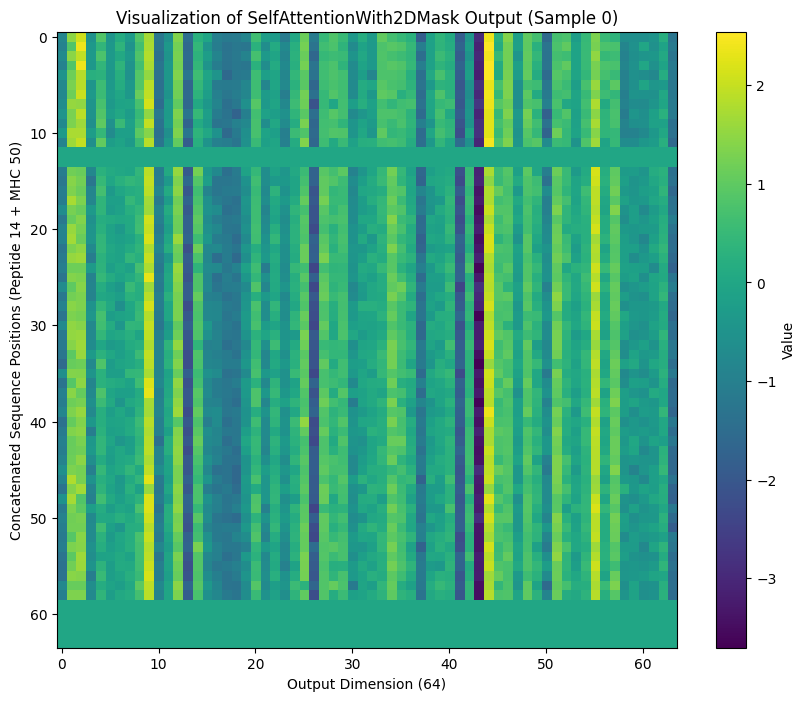

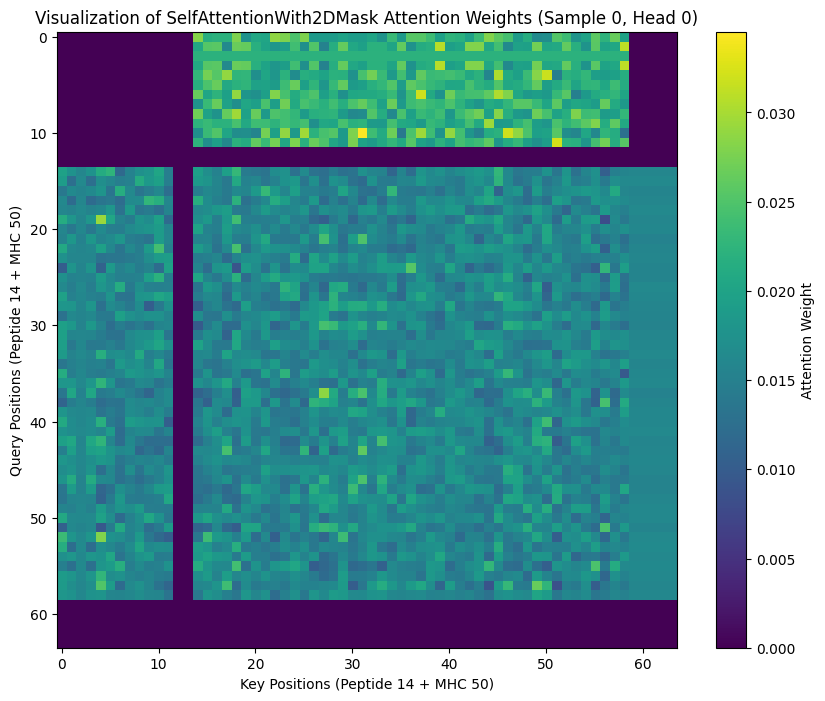

Output tensor shape: (1, 64, 64)
Attention weights shape: (1, 4, 64, 64)
Output contains NaNs: False
Output contains Infs: False
Attention weights contain NaNs: False
Attention weights contain Infs: False


In [6]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt

# Define variables for dummy data generation (smaller for visualization)
num_samples = 1  # Visualize a single sample
pep_len = 14
mhc_len = 50 # Smaller MHC length for visualization
pep_alphabet_size = 21
mhc_embedding_dim = 64 # Smaller embedding dimension for visualization

# generate dummy data for visualization
pep_indices = np.random.randint(0, pep_alphabet_size, size=(num_samples, pep_len))
pep_OHE = tf.one_hot(pep_indices, depth=pep_alphabet_size, dtype=tf.float32)

mhc_emb = tf.random.normal(shape=(num_samples, mhc_len, mhc_embedding_dim))

contact_map_logits = tf.random.normal(shape=(num_samples, pep_len, mhc_len))
contact_map = tf.nn.softmax(contact_map_logits, axis=-1)

pad_token = -2.0
mask_token = -1.0

pep_mask = np.ones((num_samples, pep_len), dtype=np.float32)
# Add some padding/masking for demonstration
pep_mask[0, -2:] = pad_token
pep_mask[0, 2] = mask_token
pep_mask = tf.constant(pep_mask, dtype=tf.float32)

mhc_mask = np.ones((num_samples, mhc_len), dtype=np.float32)
# Add some padding for demonstration
mhc_mask[0, -5:] = pad_token
mhc_mask = tf.constant(mhc_mask, dtype=tf.float32)

pep_bool_mask = tf.cast(pep_mask > 0, dtype=tf.float32)
mhc_bool_mask = tf.cast(mhc_mask > 0, dtype=tf.float32)

pep_OHE = pep_OHE * pep_bool_mask[:, :, tf.newaxis]
mhc_emb = mhc_emb * mhc_bool_mask[:, :, tf.newaxis]


# Instantiate the SelfAttentionWith2DMask layer
# query_dim and context_dim should match the last dimension of the concatenated input
attention_layer = SelfAttentionWith2DMask(
    query_dim=mhc_embedding_dim,
    context_dim=mhc_embedding_dim,
    output_dim=mhc_embedding_dim,
    heads=4, # Keep heads consistent
    return_att_weights=True, # Set to True to return attention weights
    do_not_mask_mhc=True
)

# Concatenate peptide and MHC embeddings
# Project peptide OHE to match mhc_embedding_dim
pep_proj_layer = keras.layers.Dense(mhc_embedding_dim, name='pep_projection_vis')
pep_emb_proj = pep_proj_layer(pep_OHE) # (B, P, mhc_embedding_dim)

# Concatenate along the sequence length dimension (axis=1)
x_pmhc = tf.concat([pep_emb_proj, mhc_emb], axis=1) # (B, P+M, mhc_embedding_dim)

# Call the attention layer and capture both outputs
output_attention, attention_weights = attention_layer(x_pmhc, pep_mask, mhc_mask)

# Visualize the output for the single sample
output_sample = output_attention[0].numpy() # Get the first (and only) sample

plt.figure(figsize=(10, 8))
plt.title("Visualization of SelfAttentionWith2DMask Output (Sample 0)")
plt.imshow(output_sample, aspect='auto', cmap='viridis')
plt.xlabel(f"Output Dimension ({mhc_embedding_dim})")
plt.ylabel(f"Concatenated Sequence Positions (Peptide {pep_len} + MHC {mhc_len})")
plt.colorbar(label="Value")
plt.show()

# Visualize the attention weights for the first sample and first head
attention_weights_sample_head = attention_weights[0, 0].numpy() # Get first sample, first head

plt.figure(figsize=(10, 8))
plt.title("Visualization of SelfAttentionWith2DMask Attention Weights (Sample 0, Head 0)")
plt.imshow(attention_weights_sample_head, aspect='auto', cmap='viridis')
plt.xlabel(f"Key Positions (Peptide {pep_len} + MHC {mhc_len})")
plt.ylabel(f"Query Positions (Peptide {pep_len} + MHC {mhc_len})")
plt.colorbar(label="Attention Weight")
plt.show()


print("Output tensor shape:", output_attention.shape)
print("Attention weights shape:", attention_weights.shape)

# Check for NaNs or Infs
print("Output contains NaNs:", tf.reduce_any(tf.math.is_nan(output_attention)).numpy())
print("Output contains Infs:", tf.reduce_any(tf.math.is_inf(output_attention)).numpy())
print("Attention weights contain NaNs:", tf.reduce_any(tf.math.is_nan(attention_weights)).numpy())
print("Attention weights contain Infs:", tf.reduce_any(tf.math.is_inf(attention_weights)).numpy())

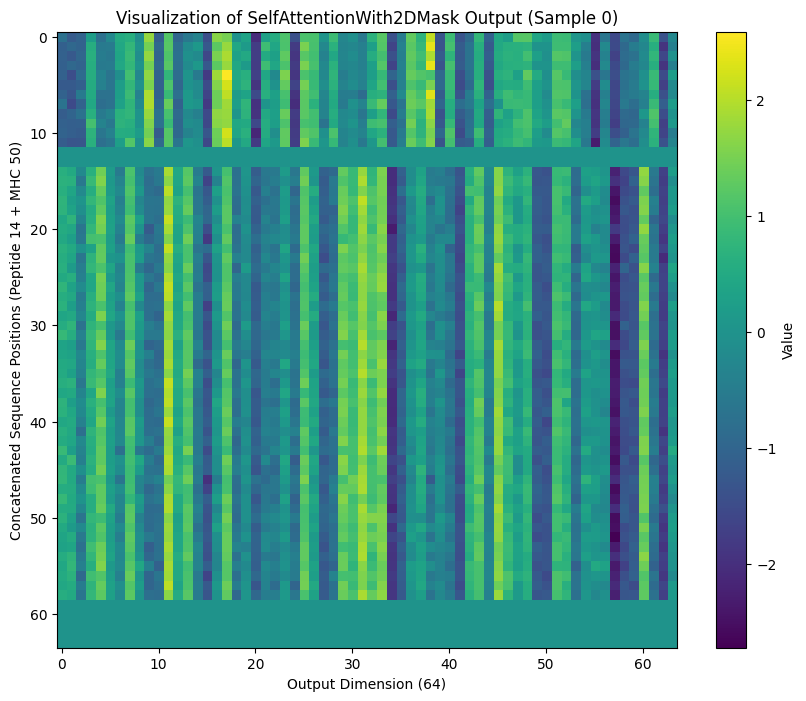

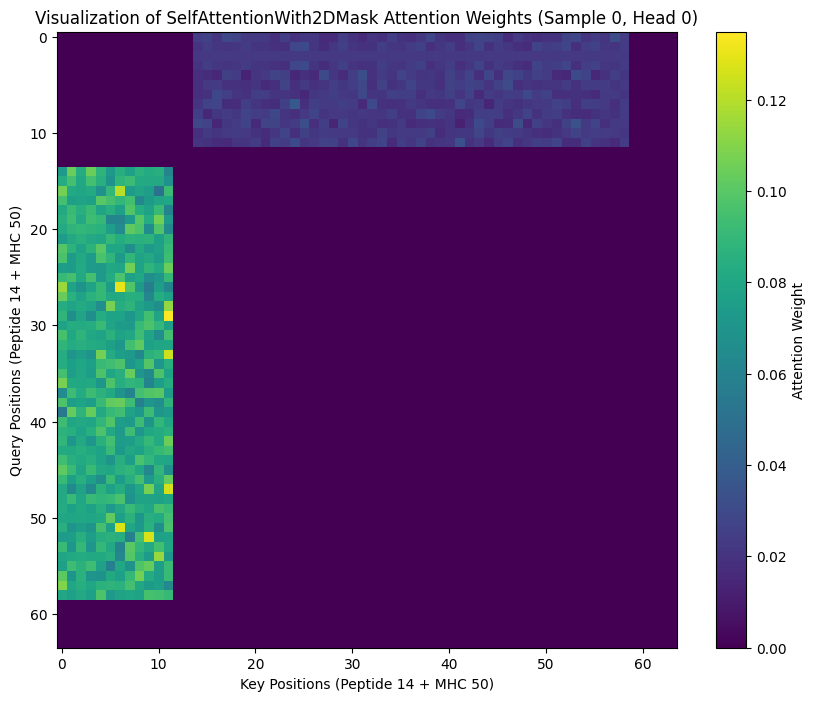

Output tensor shape: (1, 64, 64)


In [7]:

# Instantiate the SelfAttentionWith2DMask layer
# query_dim and context_dim should match the last dimension of the concatenated input
attention_layer = SelfAttentionWith2DMask(
    query_dim=mhc_embedding_dim,
    context_dim=mhc_embedding_dim,
    output_dim=mhc_embedding_dim,
    heads=4,
    return_att_weights=True,
    do_not_mask_mhc=False
)

# Concatenate peptide and MHC embeddings
# Project peptide OHE to match mhc_embedding_dim
pep_proj_layer = keras.layers.Dense(mhc_embedding_dim, name='pep_projection_vis')
pep_emb_proj = pep_proj_layer(pep_OHE) # (B, P, mhc_embedding_dim)

# Concatenate along the sequence length dimension (axis=1)
x_pmhc = tf.concat([pep_emb_proj, mhc_emb], axis=1) # (B, P+M, mhc_embedding_dim)

# Call the attention layer
output_attention, attention_weights = attention_layer(x_pmhc, pep_mask, mhc_mask)

# Visualize the output for the single sample
output_sample = output_attention[0].numpy() # Get the first (and only) sample

plt.figure(figsize=(10, 8))
plt.title("Visualization of SelfAttentionWith2DMask Output (Sample 0)")
plt.imshow(output_sample, aspect='auto', cmap='viridis')
plt.xlabel(f"Output Dimension ({mhc_embedding_dim})")
plt.ylabel(f"Concatenated Sequence Positions (Peptide {pep_len} + MHC {mhc_len})")
plt.colorbar(label="Value")
plt.show()

# Visualize the attention weights for the first sample and first head
attention_weights_sample_head = attention_weights[0, 0].numpy() # Get first sample, first head

plt.figure(figsize=(10, 8))
plt.title("Visualization of SelfAttentionWith2DMask Attention Weights (Sample 0, Head 0)")
plt.imshow(attention_weights_sample_head, aspect='auto', cmap='viridis')
plt.xlabel(f"Key Positions (Peptide {pep_len} + MHC {mhc_len})")
plt.ylabel(f"Query Positions (Peptide {pep_len} + MHC {mhc_len})")
plt.colorbar(label="Attention Weight")
plt.show()

print("Output tensor shape:", output_attention.shape)

In [8]:
! pip install --upgrade keras-hub

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 947.9/947.9 kB 18.8 MB/s eta 0:00:00
  Attempting uninstall: keras-hub
    Found existing installation: keras-hub 0.21.1
    Uninstalling keras-hub-0.21.1:
      Successfully uninstalled keras-hub-0.21.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
keras-nlp 0.21.1 requires keras-hub==0.21.1, but you have keras-hub 0.22.1 which is incompatible.


In [9]:
# RoPE implementation
from keras_hub.src.layers.modeling.rotary_embedding import RotaryEmbedding

class SelfAttentionWith2DMask(keras.layers.Layer):
    """
    Custom self-attention layer that supports 2D masks.
    """
    def __init__(self, query_dim, context_dim, output_dim, heads=4,
                 return_att_weights=False, name='SelfAttentionWith2DMask',
                 epsilon=1e-6, mask_token=-1., pad_token=-2., self_attn_mhc=True, apply_rope=True):
        super().__init__(name=name)
        self.query_dim = query_dim
        self.context_dim = context_dim
        self.output_dim = output_dim
        self.heads = heads
        self.return_att_weights = return_att_weights
        self.epsilon = epsilon
        self.mask_token = mask_token
        self.pad_token = pad_token
        self.att_dim = output_dim // heads  # Attention dimension per head
        self.self_attn_mhc = self_attn_mhc
        self.apply_rope = apply_rope # flag for rotary positional embedding

    def build(self, x):
        # Projection weights
        self.norm1 = layers.LayerNormalization(epsilon=self.epsilon, name=f'ln1_{self.name}')
        self.q_proj = self.add_weight(shape=(self.heads, self.query_dim, self.att_dim),
                                      initializer='random_normal', trainable=True, name=f'q_proj_{self.name}')
        self.k_proj = self.add_weight(shape=(self.heads, self.context_dim, self.att_dim),
                                      initializer='random_normal', trainable=True, name=f'k_proj_{self.name}')
        self.v_proj = self.add_weight(shape=(self.heads, self.context_dim, self.att_dim),
                                      initializer='random_normal', trainable=True, name=f'v_proj_{self.name}')
        self.g_proj = self.add_weight(shape=(self.heads, self.query_dim, self.att_dim),
                                      initializer='random_uniform', trainable=True, name=f'g_proj_{self.name}')
        self.norm2 = layers.LayerNormalization(epsilon=self.epsilon, name=f'ln2_{self.name}')


        self.out_w = self.add_weight(shape=(self.heads * self.att_dim, self.output_dim),
                                     initializer='random_normal', trainable=True, name=f'outw_{self.name}')
        self.out_b = self.add_weight(shape=(self.output_dim,), initializer='zeros',
                                     trainable=True, name=f'outb_{self.name}')
        self.scale = 1.0 / tf.math.sqrt(tf.cast(self.att_dim, tf.float32))

        if self.apply_rope:
            if (self.att_dim % 2) != 0:
                raise ValueError(f"RotaryEmbedding requires even att_dim, got {self.att_dim}.")
            # q/k have shape (B, H, S, D): sequence_axis=2, feature_axis=-1
            self.rope = RotaryEmbedding(sequence_axis=2, feature_axis=-1, name=f'rope_{self.name}')

    def call(self, x_pmhc, p_mask, m_mask):
        """
        Args:
            x: Tensor of shape (B, N+M, query_dim) for query.
            p_mask: Tensor of shape (B, N) for peptide mask.
            m_mask: Tensor of shape (B, M) for mhc mask.
        Returns:
            Tensor of shape (B, N+M, output_dim)
        """
        x_pmhc = self.norm1(x_pmhc)  # Normalize input
        p_mask = tf.cast(p_mask, tf.float32)
        m_mask = tf.cast(m_mask, tf.float32)
        p_mask = tf.where(p_mask==self.pad_token, x=0., y=1.)  # (B, N)
        m_mask = tf.where(m_mask==self.pad_token, x=0., y=1.)  # (B, M)

        q = tf.einsum('bxd,hde->bhxe', x_pmhc , self.q_proj)  # (B, N+M, E) * (H, E, D) -> (B, H, N+M, D)
        k = tf.einsum('bxd,hde->bhxe', x_pmhc, self.k_proj) # (B, N+M, E) * (H, E, D) -> (B, H, N+M, D)
        v = tf.einsum('bxd,hde->bhxe', x_pmhc, self.v_proj) # (B, N+M, E) * (H, E, D) -> (B, H, N+M, D)
        g = tf.einsum('bxd,hde->bhxe', x_pmhc, self.g_proj)  # (B, N+M, E) * (H, E, D) -> (B, H, N+M, D)

        if self.apply_rope:
            q = self.rope(q)
            k = self.rope(k)

        att = tf.matmul(q, k, transpose_b=True) * self.scale  # (B, H, N+M, D) * (B, H, D, N+M) -> (B, H, N+M, N+M)
        # Create 2D mask
        mask_2d = self.mask_2d(p_mask, m_mask)
        mask_2d = tf.cast(mask_2d, tf.float32)  # (B, N+M, N+M)
        mask_2d_neg = (1.0 - mask_2d) * -1e9  # Apply mask to attention scores
        att = tf.nn.softmax(att + tf.expand_dims(mask_2d_neg, axis=1), axis=-1)  # Apply softmax to attention scores
        att *= tf.expand_dims(mask_2d, axis=1) # remove the impact of row wise attention of padded tokens. since all are 1e-9
        out = tf.matmul(att, v)  # (B, H, N+M, N+M) * (B, H, N+M, D) -> (B, H, N+M, D)
        out *= tf.nn.sigmoid(g)  # Apply gating mechanism
        out = tf.transpose(out, [0, 2, 1, 3])
        out = tf.reshape(out, [tf.shape(x_pmhc)[0], tf.shape(x_pmhc)[1], self.heads * self.att_dim])
        out = tf.matmul(out, self.out_w) + self.out_b
        out = self.norm2(out)
        if self.return_att_weights:
            return out, att
        else:
            return out

    def mask_2d(self, p_mask, m_mask):
        p_mask = tf.cast(p_mask, tf.float32)
        m_mask = tf.cast(m_mask, tf.float32)
        p_mask = tf.expand_dims(p_mask, axis=-1)
        m_mask = tf.expand_dims(m_mask, axis=-1) # (B, N, 1), (B, M, 1)
        # zero square masks
        self_peptide_mask = tf.zeros_like(p_mask, dtype=tf.float32) # (B, N, 1)
        self_peptide_mask_2d = tf.broadcast_to(self_peptide_mask, (
            tf.shape(p_mask)[0], tf.shape(p_mask)[1], tf.shape(p_mask)[1])) #(B, N, N)
        if self.self_attn_mhc:
            self_mhc_mask = m_mask
        else:
            self_mhc_mask = tf.zeros_like(m_mask, dtype=tf.float32)
        self_mhc_mask_2d = tf.broadcast_to(self_mhc_mask, (
            tf.shape(m_mask)[0], tf.shape(m_mask)[1], tf.shape(m_mask)[1])) # (B, M, M)
        # one and zero masks
        pep_mhc_mask_secondpart = tf.broadcast_to(p_mask, (tf.shape(p_mask)[0], tf.shape(p_mask)[1], tf.shape(m_mask)[-1])) # (B, N, M)
        pep_mhc_mask_secondpart = pep_mhc_mask_secondpart * tf.transpose(m_mask, perm=[0, 2, 1]) # (B,N,M)*(B,1,M)=(B, N, M)
        mhc_pep_mask_secondpart = tf.broadcast_to(m_mask, (tf.shape(m_mask)[0], tf.shape(m_mask)[1], tf.shape(p_mask)[-1])) # (B, M, N)
        mhc_pep_mask_secondpart = mhc_pep_mask_secondpart * tf.transpose(p_mask, perm=[0, 2, 1]) # (B,M,N)*(B,1,N)=(B, M, N)
        # combined masks (B,N+M,N+M)
        combined_mask_1 = tf.concat([self_peptide_mask_2d, pep_mhc_mask_secondpart], axis=2) # (B, N, N+M)
        combined_mask_2 = tf.concat([mhc_pep_mask_secondpart, self_mhc_mask_2d], axis=2) # (B, M, N+M)
        final_mask = tf.concat([combined_mask_1, combined_mask_2], axis=1) # (B, N+M, N+M)
        final_mask_t = tf.transpose(final_mask, perm=[0,2,1]) # (B,... same)
        final_mask = tf.multiply(final_mask, final_mask_t)
        return final_mask

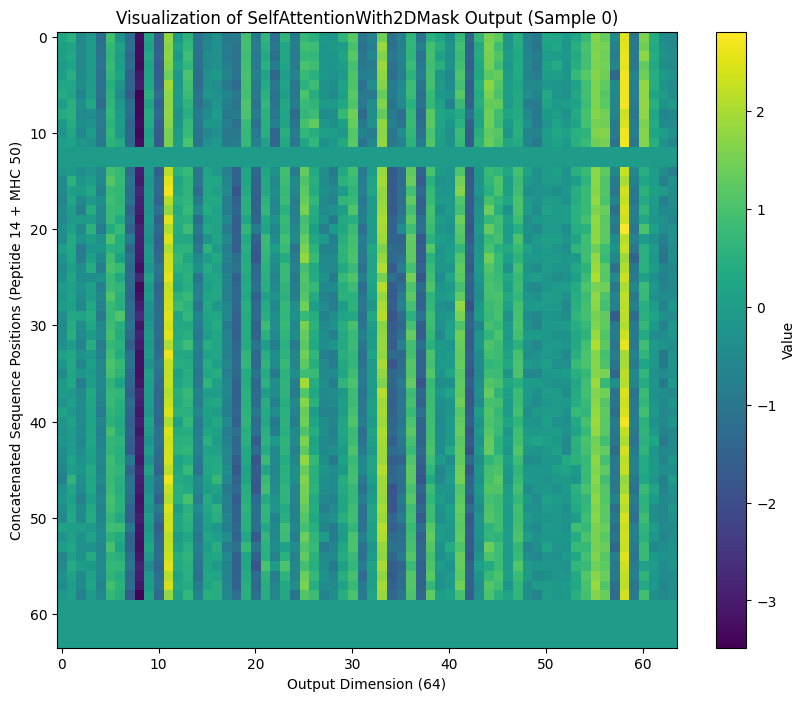

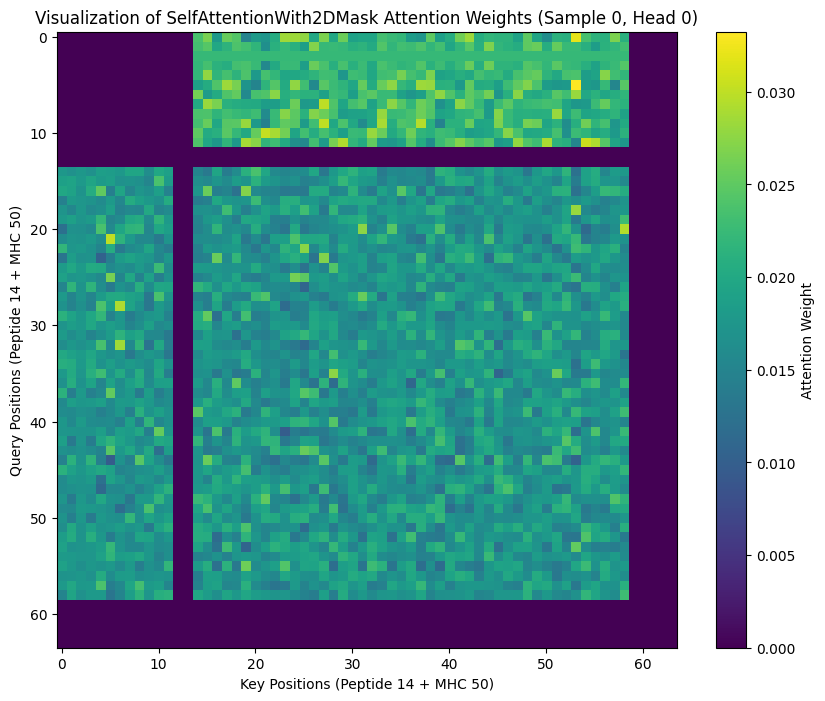

Output tensor shape: (1, 64, 64)


In [10]:

# Instantiate the SelfAttentionWith2DMask layer
# query_dim and context_dim should match the last dimension of the concatenated input
attention_layer = SelfAttentionWith2DMask(
    query_dim=mhc_embedding_dim,
    context_dim=mhc_embedding_dim,
    output_dim=mhc_embedding_dim,
    heads=4,
    return_att_weights=True,
    self_attn_mhc=True
)

# Concatenate peptide and MHC embeddings
# Project peptide OHE to match mhc_embedding_dim
pep_proj_layer = keras.layers.Dense(mhc_embedding_dim, name='pep_projection_vis')
pep_emb_proj = pep_proj_layer(pep_OHE) # (B, P, mhc_embedding_dim)

# Concatenate along the sequence length dimension (axis=1)
x_pmhc = tf.concat([pep_emb_proj, mhc_emb], axis=1) # (B, P+M, mhc_embedding_dim)

# Call the attention layer
output_attention, attention_weights = attention_layer(x_pmhc, pep_mask, mhc_mask)

# Visualize the output for the single sample
output_sample = output_attention[0].numpy() # Get the first (and only) sample

plt.figure(figsize=(10, 8))
plt.title("Visualization of SelfAttentionWith2DMask Output (Sample 0)")
plt.imshow(output_sample, aspect='auto', cmap='viridis')
plt.xlabel(f"Output Dimension ({mhc_embedding_dim})")
plt.ylabel(f"Concatenated Sequence Positions (Peptide {pep_len} + MHC {mhc_len})")
plt.colorbar(label="Value")
plt.show()

# Visualize the attention weights for the first sample and first head
attention_weights_sample_head = attention_weights[0, 0].numpy() # Get first sample, first head

plt.figure(figsize=(10, 8))
plt.title("Visualization of SelfAttentionWith2DMask Attention Weights (Sample 0, Head 0)")
plt.imshow(attention_weights_sample_head, aspect='auto', cmap='viridis')
plt.xlabel(f"Key Positions (Peptide {pep_len} + MHC {mhc_len})")
plt.ylabel(f"Query Positions (Peptide {pep_len} + MHC {mhc_len})")
plt.colorbar(label="Attention Weight")
plt.show()

print("Output tensor shape:", output_attention.shape)

In [11]:
I = 0
for i in attention_layer.weights:
  print(len(i.numpy().flatten()), 'I:', I)
  I+= len(i.numpy().flatten())
print(I)


4096 I: 0
4096 I: 4096
4096 I: 8192
4096 I: 12288
4096 I: 16384
64 I: 20480
64 I: 20544
64 I: 20608
64 I: 20672
64 I: 20736
20800


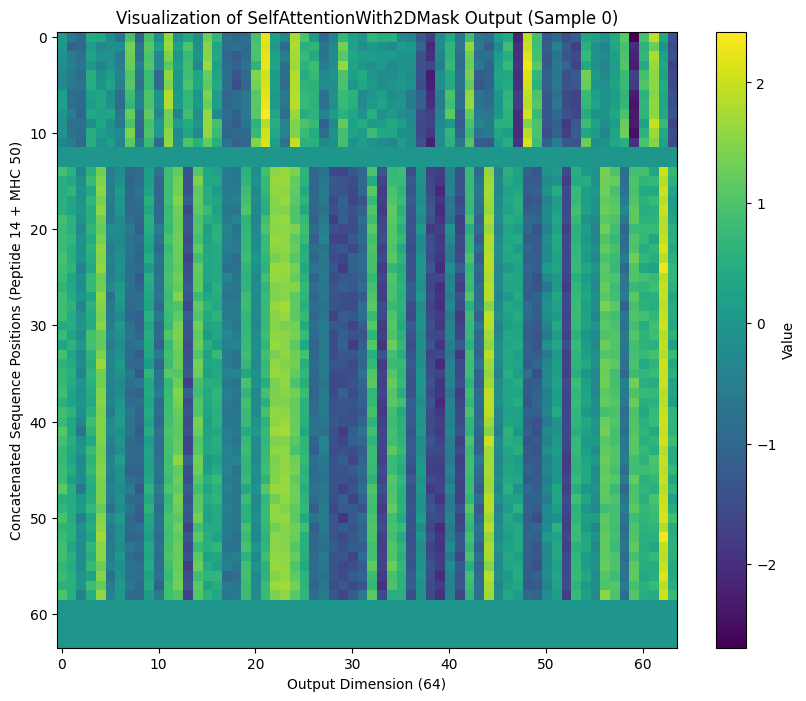

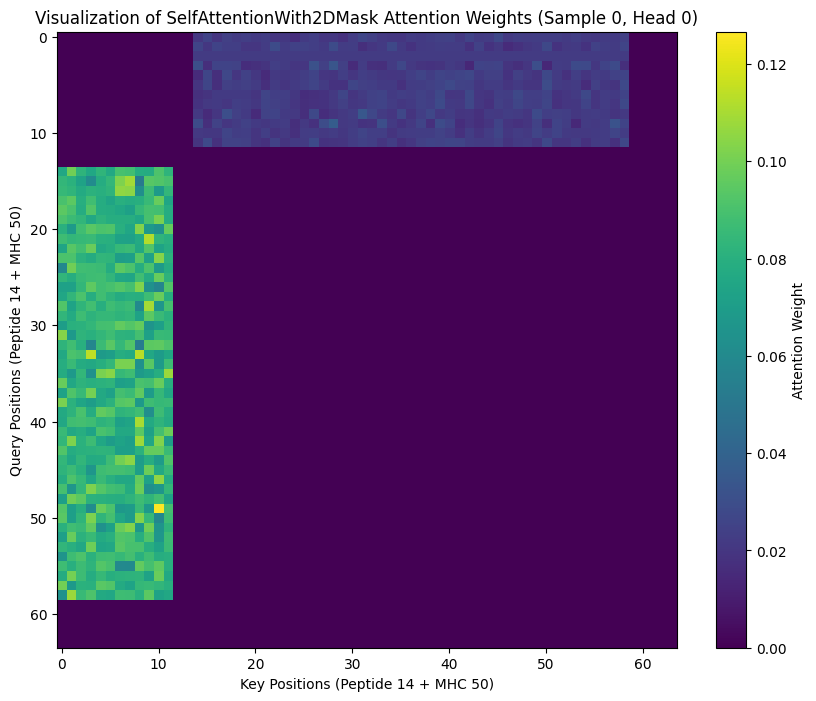

Output tensor shape: (1, 64, 64)


In [ ]:
# Instantiate the SelfAttentionWith2DMask layer
# query_dim and context_dim should match the last dimension of the concatenated input
attention_layer = SelfAttentionWith2DMask(
    query_dim=mhc_embedding_dim,
    context_dim=mhc_embedding_dim,
    output_dim=mhc_embedding_dim,
    heads=4,
    return_att_weights=True,
    self_attn_mhc=False
)

# Concatenate peptide and MHC embeddings
# Project peptide OHE to match mhc_embedding_dim
pep_proj_layer = keras.layers.Dense(mhc_embedding_dim, name='pep_projection_vis')
pep_emb_proj = pep_proj_layer(pep_OHE) # (B, P, mhc_embedding_dim)

# Concatenate along the sequence length dimension (axis=1)
x_pmhc = tf.concat([pep_emb_proj, mhc_emb], axis=1) # (B, P+M, mhc_embedding_dim)

# Call the attention layer
output_attention, attention_weights = attention_layer(x_pmhc, pep_mask, mhc_mask)

# Visualize the output for the single sample
output_sample = output_attention[0].numpy() # Get the first (and only) sample

plt.figure(figsize=(10, 8))
plt.title("Visualization of SelfAttentionWith2DMask Output (Sample 0)")
plt.imshow(output_sample, aspect='auto', cmap='viridis')
plt.xlabel(f"Output Dimension ({mhc_embedding_dim})")
plt.ylabel(f"Concatenated Sequence Positions (Peptide {pep_len} + MHC {mhc_len})")
plt.colorbar(label="Value")
plt.show()

# Visualize the attention weights for the first sample and first head
attention_weights_sample_head = attention_weights[0, 0].numpy() # Get first sample, first head

plt.figure(figsize=(10, 8))
plt.title("Visualization of SelfAttentionWith2DMask Attention Weights (Sample 0, Head 0)")
plt.imshow(attention_weights_sample_head, aspect='auto', cmap='viridis')
plt.xlabel(f"Key Positions (Peptide {pep_len} + MHC {mhc_len})")
plt.ylabel(f"Query Positions (Peptide {pep_len} + MHC {mhc_len})")
plt.colorbar(label="Attention Weight")
plt.show()

print("Output tensor shape:", output_attention.shape)

In [ ]:
# Flash Attention implementation

In [ ]:
class SelfAttentionWith2DMask(keras.layers.Layer):
    """
    Custom self-attention layer that supports 2D masks.
    """
    def __init__(self, query_dim, context_dim, output_dim, heads=4,
                 return_att_weights=False, name='SelfAttentionWith2DMask',
                 epsilon=1e-6, mask_token=-1., pad_token=-2., self_attn_mhc=True, apply_rope=True,
                 use_flash_attn=False):
        super().__init__(name=name)
        self.query_dim = query_dim
        self.context_dim = context_dim
        self.output_dim = output_dim
        self.heads = heads
        self.return_att_weights = return_att_weights
        self.epsilon = epsilon
        self.mask_token = mask_token
        self.pad_token = pad_token
        self.att_dim = output_dim // heads  # Attention dimension per head
        self.self_attn_mhc = self_attn_mhc
        self.apply_rope = apply_rope # flag for rotary positional embedding
        self.use_flash_attn = use_flash_attn  # new: opt-in fused SDPA/flash

    def build(self, x):
        # Projection weights
        self.norm1 = layers.LayerNormalization(epsilon=self.epsilon, name=f'ln1_{self.name}')
        self.q_proj = self.add_weight(shape=(self.heads, self.query_dim, self.att_dim),
                                      initializer='random_normal', trainable=True, name=f'q_proj_{self.name}')
        self.k_proj = self.add_weight(shape=(self.heads, self.context_dim, self.att_dim),
                                      initializer='random_normal', trainable=True, name=f'k_proj_{self.name}')
        self.v_proj = self.add_weight(shape=(self.heads, self.context_dim, self.att_dim),
                                      initializer='random_normal', trainable=True, name=f'v_proj_{self.name}')
        self.g_proj = self.add_weight(shape=(self.heads, self.query_dim, self.att_dim),
                                      initializer='random_uniform', trainable=True, name=f'g_proj_{self.name}')
        self.norm2 = layers.LayerNormalization(epsilon=self.epsilon, name=f'ln2_{self.name}')

        self.out_w = self.add_weight(shape=(self.heads * self.att_dim, self.output_dim),
                                     initializer='random_normal', trainable=True, name=f'outw_{self.name}')
        self.out_b = self.add_weight(shape=(self.output_dim,), initializer='zeros',
                                     trainable=True, name=f'outb_{self.name}')
        self.scale = 1.0 / tf.math.sqrt(tf.cast(self.att_dim, tf.float32))

        if self.apply_rope:
            if (self.att_dim % 2) != 0:
                raise ValueError(f"RotaryEmbedding requires even att_dim, got {self.att_dim}.")
            # q/k have shape (B, H, S, D): sequence_axis=2, feature_axis=-1
            self.rope = RotaryEmbedding(sequence_axis=2, feature_axis=-1, name=f'rope_{self.name}')

    def call(self, x_pmhc, p_mask, m_mask):
        """
        Args:
            x_pmhc: Tensor of shape (B, N+M, query_dim) for query.
            p_mask: Tensor of shape (B, N) for peptide mask.
            m_mask: Tensor of shape (B, M) for mhc mask.
        Returns:
            Tensor of shape (B, N+M, output_dim)
        """
        x_pmhc = self.norm1(x_pmhc)  # Normalize input
        p_mask = tf.cast(p_mask, tf.float32)
        m_mask = tf.cast(m_mask, tf.float32)
        p_mask = tf.where(p_mask==self.pad_token, x=0., y=1.)  # (B, N)
        m_mask = tf.where(m_mask==self.pad_token, x=0., y=1.)  # (B, M)

        q = tf.einsum('bxd,hde->bhxe', x_pmhc , self.q_proj)  # (B, H, N+M, D)
        k = tf.einsum('bxd,hde->bhxe', x_pmhc, self.k_proj)   # (B, H, N+M, D)
        v = tf.einsum('bxd,hde->bhxe', x_pmhc, self.v_proj)   # (B, H, N+M, D)
        g = tf.einsum('bxd,hde->bhxe', x_pmhc, self.g_proj)   # (B, H, N+M, D)

        if self.apply_rope:
            q = self.rope(q)
            k = self.rope(k)

        # Create 2D mask
        mask_2d = self.mask_2d(p_mask, m_mask)               # (B, N+M, N+M), 1=allowed, 0=masked
        mask_2d = tf.cast(mask_2d, q.dtype)
        mask_bias = (1.0 - mask_2d) * tf.constant(-1e9, dtype=q.dtype)  # additive mask bias
        mask_bias = tf.expand_dims(mask_bias, axis=1)        # (B, 1, T, S) broadcast over heads

        can_use_flash = (
            self.use_flash_attn and
            hasattr(tf.nn, "scaled_dot_product_attention") and
            (not self.return_att_weights)
        )

        if can_use_flash:
            # Fused SDPA path (uses flash kernel when available). It applies scaling internally.
            out = tf.nn.scaled_dot_product_attention(q, k, v, mask=mask_bias)  # (B, H, T, D)

            # Match original behavior: zero-out outputs for rows with no valid targets (e.g., padded queries).
            row_mask = tf.reduce_max(mask_2d, axis=-1, keepdims=True)          # (B, T, 1), 1 if any target allowed
            out *= tf.expand_dims(row_mask, axis=1)                            # (B, 1, T, 1)
            att = None  # not available in fused path
        else:
            # Original path
            att = tf.matmul(q, k, transpose_b=True) * self.scale              # (B, H, T, T)
            att = att + mask_bias                                             # add -inf where masked
            att = tf.nn.softmax(att, axis=-1)
            # remove the impact of row-wise attention of padded tokens. since all are 1e-9
            att *= tf.expand_dims(mask_2d, axis=1)                            # (B, H, T, T)
            out = tf.matmul(att, v)                                           # (B, H, T, D)

        out *= tf.nn.sigmoid(g)  # Apply gating mechanism
        out = tf.transpose(out, [0, 2, 1, 3])
        out = tf.reshape(out, [tf.shape(x_pmhc)[0], tf.shape(x_pmhc)[1], self.heads * self.att_dim])
        out = tf.matmul(out, self.out_w) + self.out_b
        out = self.norm2(out)
        if self.return_att_weights:
            return out, att
        else:
            return out

    def mask_2d(self, p_mask, m_mask):
        p_mask = tf.cast(p_mask, tf.float32)
        m_mask = tf.cast(m_mask, tf.float32)
        p_mask = tf.expand_dims(p_mask, axis=-1)
        m_mask = tf.expand_dims(m_mask, axis=-1) # (B, N, 1), (B, M, 1)
        # zero square masks
        self_peptide_mask = tf.zeros_like(p_mask, dtype=tf.float32) # (B, N, 1)
        self_peptide_mask_2d = tf.broadcast_to(self_peptide_mask, (
            tf.shape(p_mask)[0], tf.shape(p_mask)[1], tf.shape(p_mask)[1])) #(B, N, N)
        if self.self_attn_mhc:
            self_mhc_mask = m_mask
        else:
            self_mhc_mask = tf.zeros_like(m_mask, dtype=tf.float32)
        self_mhc_mask_2d = tf.broadcast_to(self_mhc_mask, (
            tf.shape(m_mask)[0], tf.shape(m_mask)[1], tf.shape(m_mask)[1])) # (B, M, M)
        # one and zero masks
        pep_mhc_mask_secondpart = tf.broadcast_to(p_mask, (tf.shape(p_mask)[0], tf.shape(p_mask)[1], tf.shape(m_mask)[-1])) # (B, N, M)
        pep_mhc_mask_secondpart = pep_mhc_mask_secondpart * tf.transpose(m_mask, perm=[0, 2, 1]) # (B,N,M)*(B,1,M)=(B, N, M)
        mhc_pep_mask_secondpart = tf.broadcast_to(m_mask, (tf.shape(m_mask)[0], tf.shape(m_mask)[1], tf.shape(p_mask)[-1])) # (B, M, N)
        mhc_pep_mask_secondpart = mhc_pep_mask_secondpart * tf.transpose(p_mask, perm=[0, 2, 1]) # (B,M,N)*(B,1,N)=(B, M, N)
        # combined masks (B,N+M,N+M)
        combined_mask_1 = tf.concat([self_peptide_mask_2d, pep_mhc_mask_secondpart], axis=2) # (B, N, N+M)
        combined_mask_2 = tf.concat([mhc_pep_mask_secondpart, self_mhc_mask_2d], axis=2) # (B, M, N+M)
        final_mask = tf.concat([combined_mask_1, combined_mask_2], axis=1) # (B, N+M, N+M)
        return final_mask

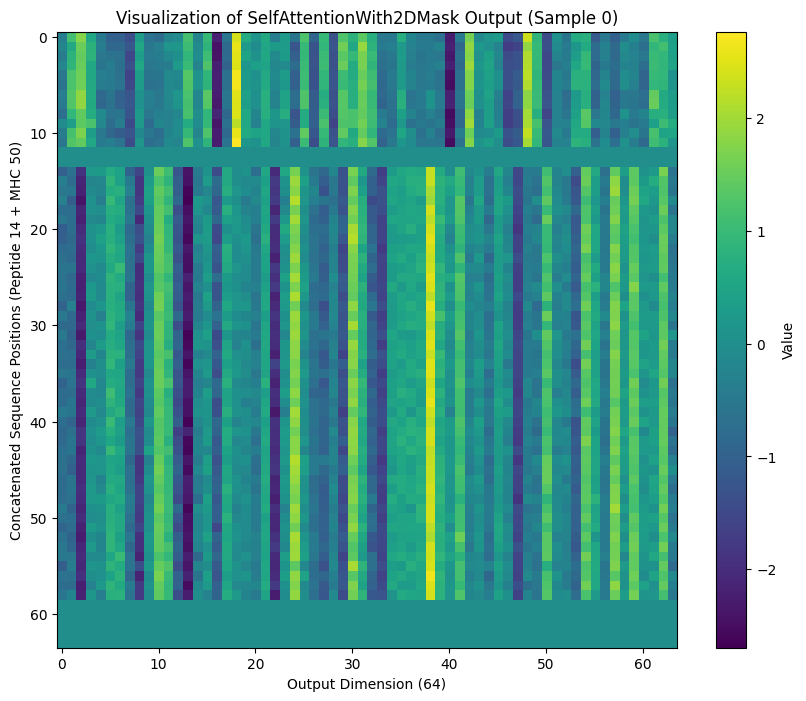

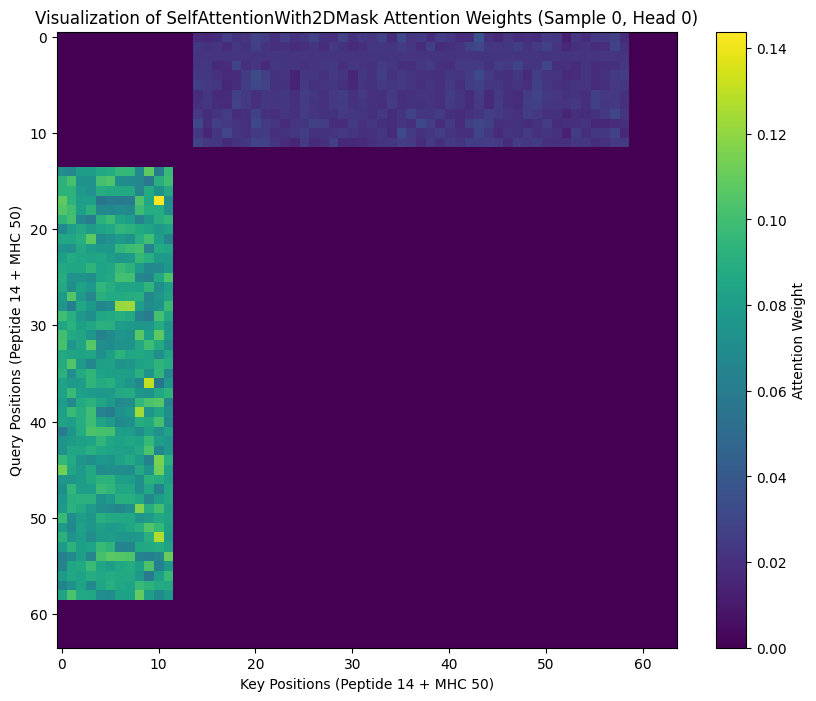

Output tensor shape: (1, 64, 64)


In [ ]:
# Instantiate the SelfAttentionWith2DMask layer
# query_dim and context_dim should match the last dimension of the concatenated input
attention_layer = SelfAttentionWith2DMask(
    query_dim=mhc_embedding_dim,
    context_dim=mhc_embedding_dim,
    output_dim=mhc_embedding_dim,
    heads=4,
    return_att_weights=True,
    self_attn_mhc=False,
    use_flash_attn=True
)

# Concatenate peptide and MHC embeddings
# Project peptide OHE to match mhc_embedding_dim
pep_proj_layer = keras.layers.Dense(mhc_embedding_dim, name='pep_projection_vis')
pep_emb_proj = pep_proj_layer(pep_OHE) # (B, P, mhc_embedding_dim)

# Concatenate along the sequence length dimension (axis=1)
x_pmhc = tf.concat([pep_emb_proj, mhc_emb], axis=1) # (B, P+M, mhc_embedding_dim)

# Call the attention layer
output_attention, attention_weights = attention_layer(x_pmhc, pep_mask, mhc_mask)

# Visualize the output for the single sample
output_sample = output_attention[0].numpy() # Get the first (and only) sample

plt.figure(figsize=(10, 8))
plt.title("Visualization of SelfAttentionWith2DMask Output (Sample 0)")
plt.imshow(output_sample, aspect='auto', cmap='viridis')
plt.xlabel(f"Output Dimension ({mhc_embedding_dim})")
plt.ylabel(f"Concatenated Sequence Positions (Peptide {pep_len} + MHC {mhc_len})")
plt.colorbar(label="Value")
plt.show()

# Visualize the attention weights for the first sample and first head
attention_weights_sample_head = attention_weights[0, 0].numpy() # Get first sample, first head

plt.figure(figsize=(10, 8))
plt.title("Visualization of SelfAttentionWith2DMask Attention Weights (Sample 0, Head 0)")
plt.imshow(attention_weights_sample_head, aspect='auto', cmap='viridis')
plt.xlabel(f"Key Positions (Peptide {pep_len} + MHC {mhc_len})")
plt.ylabel(f"Query Positions (Peptide {pep_len} + MHC {mhc_len})")
plt.colorbar(label="Attention Weight")
plt.show()

print("Output tensor shape:", output_attention.shape)